In [32]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Helper libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from keras.layers.core import Flatten, Dense, Reshape
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras import initializers
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
# Unpickle data file
pickle_path = 'C:/Users/Harry/Desktop/ECEC487/data/pickledDf.pkl'
df = pd.read_pickle(pickle_path)

# Split the dataframe to Wake, REM and NREM dataframes based on labels
#wake_df = df[df['Label'] == 0] # Size: 6376080 rows for 4 channels
#rem_df = df[df['Label'] == 1] # Size: 39310560 rows for 4 channels
#nrem_df = df[df['Label'] == 2] # Size: 23854560 rows for 4 channels

# Setup training and testing set (80% Training / 20% Testing)
#train_df, test_df = train_test_split(df, test_size=0.2)

# [TRAINING]
# Setup Label dataframe 
#train_label_df = train_df.filter(like='Label')
# Setup Data dataframe
#train_data_df = train_df.drop(['Label'], axis=1)

# [TESTING]
# Setup Label dataframe 
#test_label_df = test_df.filter(like='Label')
# Setup Data dataframe
#test_data_df = test_df.drop(['Label'], axis=1)

# train_df Size: 55632960 
# test_df Size: 13908240
#print (train_data_df) 
#print(train_label_df)
#print (test_data_df)
#print(test_label_df)

In [5]:
# Create input features and target variables
X = df.iloc[:,0:4]
y = df.iloc[:,-1]

# Feature Scaling Standardize the input feature so scale from -1 to 1
sc = StandardScaler()
X = sc.fit_transform(X)

In [6]:
# Split input features and target variables into training dataset and test dataset. 
# Training Set: 70% Testing Set: 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(y_train)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

In [8]:
model = Sequential()
model.add(Dense(1000, activation="relu", input_dim=4, kernel_initializer=initializers.random_normal(stddev=0.01)))
model.add(Dense(100, activation="relu"))
model.add(Dense(100, activation="relu"))

# Output layer with x nodes (one for each possible letter/number we predict)
# Softmax for more than two cateorgires to be predicted. # 3 Outputs = 3 nodes
model.add(Dense(3, activation="softmax"))

# Compiling the neural network
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

# Train the neural network
#result = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 1000, epochs=1, verbose=1)
result = model.fit(X_train, y_train, batch_size = 100000, epochs=1, verbose=1)
#result = model.fit(X_train, y_train)

# Save the trained model to disk
MODEL_FILENAME = "sleep_model.hdf5"
model.save(MODEL_FILENAME)

Epoch 1/1
55632960/55632960 [==============================] - 338s 6us/step - loss: 0.4862 - accuracy: 0.7482


In [ ]:
# Load Model
model = load_model('sleep_model.h5')

In [9]:
# Run Test Dataset WITH Label on Model to get loss and accuracy
score = model.evaluate(X_test, y_test,verbose=1)
print(score) # First

13908240/13908240 [==============================] - 531s 38us/step
[0.44980649217606405, 0.772258460521698]


In [38]:
# Get Label Prediction using Test Dataset
y_pred = model.predict(X_test)
print (y_pred)

[[0.0723311  0.47473204 0.45293686]
 [0.03126941 0.45454076 0.51418984]
 [0.05115277 0.6636244  0.2852228 ]
 ...
 [0.283949   0.54707265 0.16897835]
 [0.04453767 0.41771883 0.53774357]
 [0.08215461 0.5140478  0.40379757]]


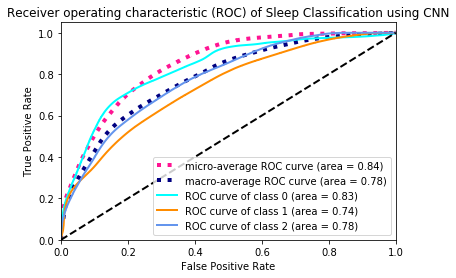

In [18]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
n_classes = y_train.shape[1]

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.subplots(figsize=(5,10))
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) of Sleep Classification using CNN')
plt.legend(loc="lower right")
plt.show()

In [25]:
print (y_pred)
print (y_test)

[[0.0723311  0.47473204 0.45293686]
 [0.03126941 0.45454076 0.51418984]
 [0.05115277 0.6636244  0.2852228 ]
 ...
 [0.283949   0.54707265 0.16897835]
 [0.04453767 0.41771883 0.53774357]
 [0.08215461 0.5140478  0.40379757]]
[[0 1 0]
 [0 1 0]
 [0 0 1]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [39]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [40]:
print (matrix)

[[ 183938  847092  244024]
 [  86145 6187898 1587408]
 [   8027 2017685 2746023]]
